# TCN Modeling - With Masking
----
This notebook handles attempting various configurations of TCN modeling with options to include other time-distributed pre and post-processing layers. First, we will need to import the various libraries and classes that we have created/chosen to use. Importantly, in this notebook we want to test the use of the newly implemented masking functionality, which separates out those portions of the images which correspond to fixed values so that the modeling resources can be devoted to focus on sea ice regions.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from geotiff_processor import GeotiffProcessor
from ice_modeler import IceModeler

Using TensorFlow backend.


## Importing the Image Index for the Northern Hemisphere's GeoTiff Files

Here we use Pandas to do a bit of formatting of the dataframe so that it can be interpreted by our modeling class. Notably we need to have a date index for time-series analysis.

In [3]:
geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv')
geotiff_index.date = pd.to_datetime(geotiff_index.date)
geotiff_index = geotiff_index.set_index('date')

Since we initially downloaded extent type files as well as concentration type files, let's subset so that we only consider concentration images for this analysis.

In [4]:
geotiff_concentration = geotiff_index.loc[geotiff_index.image_type == 'concentration']

And for testing purposes, we will choose only a small portion of images, so that we can minimize the amount of time that is spent training the model for this initial investigation.

In [5]:
conc_index = geotiff_concentration.loc['2010-01-01':'2018-12-31',:]

Next we need to create an appropriate Geotiff Processor object with the new dataframe as the index. Most importantly, this processor will handle our annual sampling process for training of the model.

In [6]:
conc_processor = GeotiffProcessor('raw_images/', image_index=conc_index)

First, however, we need to impute any missing dates that may exist in the dataframes index with the appropriate method. This is more important for the earlier years present in the database of images, as in the earlier days images were only captured every two days.

In [7]:
conc_index = conc_processor.impute_missing_index_dates(set_this_index = True)
conc_index

,Unnamed: 0,file_name,hemisphere,image_type
date,,,,
2010-01-01,N_20100101_concentration_v3.0,daily/geotiff/2010/N_20100101_concentration_v3...,north,concentration
2010-01-02,N_20100102_concentration_v3.0,daily/geotiff/2010/N_20100102_concentration_v3...,north,concentration
2010-01-03,N_20100103_concentration_v3.0,daily/geotiff/2010/N_20100103_concentration_v3...,north,concentration
2010-01-04,N_20100104_concentration_v3.0,daily/geotiff/2010/N_20100104_concentration_v3...,north,concentration
2010-01-05,N_20100105_concentration_v3.0,daily/geotiff/2010/N_20100105_concentration_v3...,north,concentration
...,...,...,...,...
2018-12-27,N_20181227_concentration_v3.0,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,N_20181228_concentration_v3.0,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,N_20181229_concentration_v3.0,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration


We are now ready to load in the default colormaps so that when can appropriately color our predicted images.

In [8]:
conc_processor.load_default_colormaps(
    extent='default_extent_colormap.pkl',
    concentration='default_concentration_colormap.pkl')
# conc_last_ten = conc_processor.impute_missing_index_dates(set_this_index=True)

## Modeling
Now that the processor and appropriate image index have been prepared, we can instantiate a new IceModeler class and begin to train the model using a train-test split.

In [9]:
ice_modeler = IceModeler()

Here, we perform the annual sampling process with the appropriate method. We will also normalize these images for the purposes of training our model.

In [10]:
conc_images, years = conc_processor.process_images_channels_first_yearly_sample()

Let's try using our new masking procedures to see if we can try to get better modeling results this time around. We will later recompose our predictions with their associated masks.

In [11]:
conc_masks, masked_images, removed_values = ice_modeler.process_image_masks(conc_images)

Finally, let's make a train-test split along with storing away the final year's worth of images for our final test predictions. First we will check to make sure that the scaling procedure is working with masked values.

In [33]:
normed_images = ice_modeler.scale_to_normal(masked_images, image_type='concentration', masked=True)

In [34]:
np.min(normed_images)

0.0

In [35]:
np.max(normed_images)

1.0

In [51]:
x_train = normed_images[:-3]
y_train = normed_images[1:-2]
x_test = normed_images[-3:-1]
y_test = normed_images[-2:]
pred_year = normed_images[-1]

In [52]:
x_train.shape

(6, 365, 1, 448, 304)

In [53]:
y_train.shape

(6, 365, 1, 448, 304)

In [54]:
x_test.shape

(2, 365, 1, 448, 304)

In [55]:
y_test.shape

(2, 365, 1, 448, 304)

Let's add some layer's to our model. For now, we will leave out the initial convolution layer from our model, in an effort to nail down some particular working parameters for our TCN layers first, as these will prove more critical I would imagine. Because our images remain in image form, we should start with a single time-distributed flattening layer so that the images are appropriately shaped for TCN analysis. We can reshape them at the end of the chain back into image form, so that we can generate the images. In between, we will start with one TCN layer followed by a time-distributed dense layer to condense the information.

In [60]:
ice_modeler.reset_model()
#ice_modeler.add_n_td_conv2d(1, filters=4, kernel_size=(4,4), padding='same')
#ice_modeler.add_td_avg_pool(pool_size=(4,4), strides=2, padding='valid')
ice_modeler.add_td_flatten()
ice_modeler.add_n_tcn(1, nb_filters=6, kernel_size=3, nb_stacks=5, activation='relu', kernel_initializer='he_uniform', dropout_rate=0.1)
ice_modeler.add_n_tcn(1, nb_filters=6, kernel_size=7, nb_stacks=5, activation='relu', kernel_initializer='he_uniform', dropout_rate=0.1)
ice_modeler.add_n_tcn(1, nb_filters=5, kernel_size=30, nb_stacks=5, activation='relu', kernel_initializer='he_uniform', dropout_rate=0.1)
ice_modeler.add_n_td_dense(1, ice_modeler.im_size, activation='relu', kernel_initializer='he_uniform', l2_amt=0.1)
ice_modeler.add_td_im_reshape()

Because this is ultimately a regression analysis, albeit on a rather large scale, we should probably use the mean-squared-error as our loss function for optimization. Perhaps other losses will work better, but this is a tried and true loss function for regression analysis and is definitely the best place to start. This loss function is also a good metric on our overall model performance, as it directly measures the difference in pixel values across the board.

In [61]:
ice_modeler.compile(loss='mean_squared_error', optimizer='adam')

Now we can fit the model.

In [62]:
ice_modeler.fit(x_train, y_train, epochs=12)

Epoch 1/12
6/6 [==============================] - 198s 33s/step - loss: nan             
Epoch 2/12
2/6 [=========>....................] - ETA: 10s - loss: nan

KeyboardInterrupt: 

In [44]:
predictions = ice_modeler.predict(x_test)

In [45]:
predictions.shape

(2, 365, 1, 448, 304)

In [46]:
predictions_images = ice_modeler.scale_from_normal(predictions, image_type='concentration', masked=True)

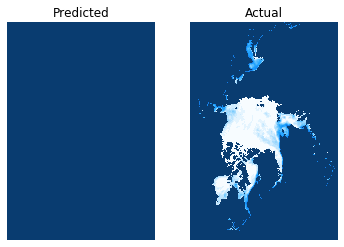

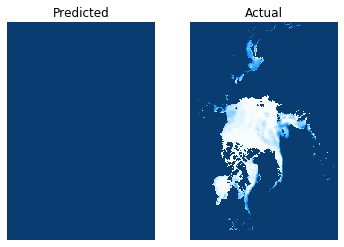

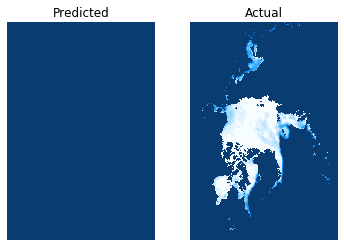

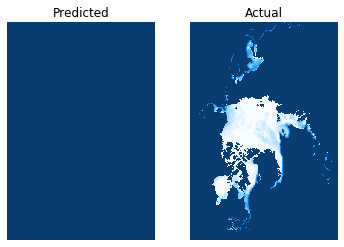

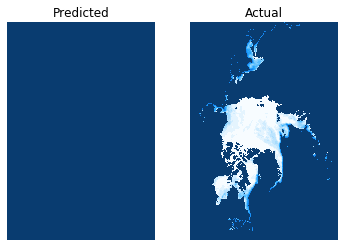

In [48]:
for i in range(5):
    frame = predictions_images[0, i, :, :]
    actual = ice_modeler.scale_from_normal(y_test[0, i, :, :], image_type='concentration', masked=True)
    conc_processor.make_side_by_side_image(frame, actual, image_type='concentration')
